#  Lab Instruction

In this notebook, we will learn how to implement DQN using Tensorflow for the [Cartpole environment in OpenAI gym](https://gym.openai.com/envs/CartPole-v0/). The notebook contains all the info that you need to understand the basic mechanism of DQN, you could also refer to the DQN pdf for detailed pseudocode. **Your task** is to fill in the

YOUR CODE HERE

sections in the code blocks below, to complete the building of computation graph, and the implementation of other parts of DQN. You are free to tweak all codes except the last block. Your are also free to tweak the hyper-parameters to improve the performance of the agent. The final block of the code evaluates the performance of the agent on an independent 100 episodes on the environment and print out the average testing performance.

Make sure that your final submission is a notebook that can be run from beginning to end, and you should print out the accuracy at the end of the notebook (i.e. be sure to run the last block after training). Your agent's performance is expected to reach near 200 at the end of training. **Your grade will depend on the final evaluation performance of the agent**. However, if you tweak the code to report false result, you will receive no credit for this assignment.

In [1]:
import tensorflow as tf

from collections import deque
from __future__ import print_function

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import gym

## DQN (Deep Q Network)

In previous Labs, we have learned to use Tensorflow to build deep learning models. In this lab, we will apply deep learning as function approximations in reinforcement learning. 

Reference: DQN https://arxiv.org/abs/1312.5602

In tabular Q-learning, we maintain a table of state-action pairs $(s,a)$ and save one action value for each entry $Q(s,a),\forall (s,a)$. At each time step $t$, we are in state $s_t$, then we choose action based on $\epsilon-$greedy strategy. With prob $\epsilon$, choose action uniformly random; with prob $1-\epsilon$, choose action based on $$a_t = \arg\max_a Q(s_t,a)$$ 

We then get the instant reward $r_t$, update the Q-table using the following rule

$$Q(s_t,a_t) \leftarrow (1-\alpha)Q(s_t,a_t) + \alpha (r_t + \max_a \gamma Q(s_{t+1},a))$$

where $\alpha \in (0,1)$ is learning rate. The algorithm is shown to converge in tabular cases. However, in cases where we cannot keep a table for state and action, we need function approximation. Consider using neural network with parameter $\theta$, the network takes as input state $s$ and action $a$. (*or some features of state and action*). Let $Q_\theta(s,a)$ be the output of the network, which estimates the optimal Q-value function for state $s$ and action $a$.
[//]: $$Q_\theta(s,a) \approx Q^\ast(s,a)$$

### Bellman optimality equation

We wish to train the neural network in order to find $\theta$ such that $Q_\theta(s,a)$ approximates $Q^*(s,a)$. 
We will use Bellman optimality equation to do this. Recall that for optimal Q function $Q^\ast(s,a)$ the following holds for all $(s,a)$

$$Q^\ast(s,a) = \max_{a'} \mathbb{E}_{s'}\big[R(s,a) + \gamma Q^\ast(s',a)\big]$$

We can use observations of form $(s_i, a_i, r_i, s'_{i})$ (i.e., observing reward $r_i$ and new state $s'_{i}$ on taking action $a_i$ in state $s_i$) for training. Let  $target_i = \max_a \mathbb{E}\big[r_i + \gamma Q^\ast(s'_{i},a)\big]$

Then, Q-learning with function approximation uses online gradient descent to find $\theta$ that minimizes the loss function

$$\frac{1}{N} \sum_{i=1}^N (Q_\theta(s_i,a_i) - target_i)^2$$

Let us first build a neural network $Q_\theta(s,a)$ as required above.

In [2]:
# define neural net Q_\theta(s,a) as a class

class Qfunction(object):
    
    def __init__(self, obssize, actsize, sess, optimizer):
        """
        obssize: dimension of state space
        actsize: dimension of action space
        sess: sess to execute this Qfunction
        optimizer: 
        """
        # YOUR CODE HERE
        # build the prediction graph
        state = tf.placeholder(tf.float32, [None, obssize])
        h_size1 = 64
        h_size2 = 64
        
        #hidden layer 1
        W_1 = weight_variable([obssize, h_size1])
        b_1 = bias_variable([h_size1])
        h_1 = tf.nn.relu(tf.matmul(state, W_1) + b_1)
        
        #hidden layer 2
        W_2 = weight_variable([h_size1, h_size2])
        b_2 = bias_variable([h_size2])
        h_2 = tf.nn.relu(tf.matmul(h_1, W_2) + b_2)
        
        #output
        W_o = weight_variable([h_size2, actsize])
        b_o = bias_variable([actsize])
        Qvalues = tf.matmul(h_2, W_o) + b_o      
        
        # build the targets and actions
        # targets represent the terms E[r+gamma Q] in Bellman equations
        # actions represent a_t
        targets = tf.placeholder(tf.float32, [None])
        actions = tf.placeholder(tf.int32, [None])
        one_hot_action = tf.one_hot(actions, actsize) #for getting desired Q(s,a)
        Qpreds = tf.reduce_sum(Qvalues * one_hot_action, axis=1)
        
        #normalization to speed up training
        #Qp_m, Qp_var = tf.nn.moments(Qpreds, axes = [0])
        #t_mean, t_var = tf.nn.moments(targets, axes = [0])
        
        #Qpreds = (Qpreds - Qp_m) / tf.sqrt(Qp_var)
        #targets = (targets - t_mean) / tf.sqrt(t_var)
        
        #loss
        loss = tf.reduce_mean(tf.square(Qpreds - targets))

        # optimization
        self.train_op = optimizer.minimize(loss)
        
        # some bookkeeping
        self.actsize = actsize
        self.Qvalues = Qvalues
        self.state = state
        self.actions = actions
        self.targets = targets
        self.loss = loss
        self.sess = sess
    
    def get_Qvalues(self, Qvalues, actions):
        """
        Retrieves Qvalues for a specific action
        """
        one_hot_action = tf.one_hot(actions, self.actsize)
        return self.sess.run(tf.reduce_sum(Qvalues * one_hot_action, axis=1))
    
    def compute_Qvalues(self, states):
        """
        states: numpy array as input to the neural net, states should have
        size [numsamples, obssize], where numsamples is the number of samples
        output: Q values for these states. The output should have size 
        [numsamples, actsize] as numpy array
        """
        return self.sess.run(self.Qvalues, feed_dict={self.state: states})

    def train(self, states, actions, targets):
        """
        states: numpy array as input to compute loss (s)
        actions: numpy array as input to compute loss (a)
        targets: numpy array as input to compute loss (Q targets)
        """
        return self.sess.run([self.loss,self.train_op], feed_dict={self.state:states, self.actions:actions, self.targets:targets})

def weight_variable(shape):
    init = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init)
    
def bias_variable(shape):
    init = tf.constant(0.1, shape=shape)
    return tf.Variable(init)

Now that we have $Q_\theta(s,a)$ we can execute policies in the environment as follows ($\epsilon-$greedy).

In [3]:
# just pseudocode
# the following lines illustrate how DQN agent takes actions 
# to interact with the environment

#raise ValueError("cannot attemp to run pseudocode")

#env = gym.make('CartPole-v0')
#epsilon = .1

#obs = env.reset()
#done = False
#rewardsum = 0

#while not done:
#    if np.random.rand() < epsilon:
#        action = env.action_space.sample()
#    else:
#        Q = Qfunction.compute_Qvalues(obs)
#        action = np.argmax(Q)  # need some tweeking of code here
#    
#    obs, reward, done, info = env.step(action)
#    rewardsum += reward
#    
#print("reward under current policy %f ".format(rewardsum)) 

We can hence collect a bunch of samples $(s_t,a_t,r_t,s_{t+1})$, and compute the targets using the current network. Let the target be $d_i$ as the $i$th target

$$d_i = \max_a r_t + \gamma Q_\theta(s_{t+1},a)$$

And then feed this value into the computational graph and minimize the Bellman error loss. This procedure has been shown to be fairly unstable. The reference paper has offered two techniques to stabilize the training process: target network and replay buffer.

**Replay Buffer**
Maintain a buffer $R$ to store trainsition tuples $(s_t,a_t,r_t,s_{t+1})$, when we minimize the Bellman error. When optimizing the Bellman error loss, we sample batches from the replay buffer and compute gradients for update on these batches. In particular, in each update, we sample $N$ tuples from buffer $(s_t,a_t,r_t,s_{t+1}) \sim R$ and then compute
loss 

$$\frac{1}{N} \sum_{i=1}^N (Q_\theta(s_i,a_i) - \max_a (r_i + \gamma Q_\theta(s_i^\prime,a))^2$$

and update parameters using backprop.

**Target Network**
Maintain a target network in addition to the original principal network. The target network is just a copy of the original network but the parameters are not updated by gradients. The target network $\theta_{\text{target}}$ is copied from the principal network every $\tau$ time steps. Target network is used to compute the targets for update

$$d_i = \max_a r_t + \gamma Q_{\theta^{-}}(s_{i}^\prime,a)$$

the targets are used in the loss function to update the principal network parameters. This slowly updated target network ensures that the targets come from a relatively stationary distribution and hence stabilize learning.

Hence several critical parts of the complete pseudocode for DQN is as follows:

**Initialization**: principal network $Q_\theta(s,a)$, target network $Q_{\theta^{-}}(s,a)$. Replay buffer $R = \{\}$ (empty). 

**At each time step $t$**: execute action using $\epsilon-$greedy based on the principal network $Q_\theta(s,a)$. To update $\theta$: sample $N$ tuples $(s_i,a_i,r_i,s_i^\prime) \sim R$, compute empirical loss 

$$\frac{1}{N} \sum_{i=1}^N (Q_\theta(s_i,a_i) - \max_a (r_i + \gamma Q_{\theta^{-}}(s_i^\prime,a))^2$$

and update parameter $\theta$ using backprop (just take one gradient step).

**Update target network**: Every $\tau$ time steps, update target network by copying $\theta_{\text{target}} \leftarrow \theta$.

In [4]:
# Implement replay buffer
class ReplayBuffer(object):
    
    def __init__(self, maxlength):
        """
        maxlength: max number of tuples to store in the buffer
        if there are more tuples than maxlength, pop out the oldest tuples
        """
        self.buffer = deque()
        self.number = 0
        self.maxlength = maxlength
    
    def append(self, experience):
        """
        this function implements appending new experience tuple
        experience: a tuple of the form (s,a,r,s^\prime, priority)
        """
        self.buffer.append(experience)
        self.number += 1
        
    def pop(self):
        """
        pop out the oldest tuples if self.number > self.maxlength
        """
        while self.number > self.maxlength:
            self.buffer.popleft()
            self.number -= 1
    
    def sample(self, batchsize):
        """
        this function samples 'batchsize' experience tuples
        batchsize: size of the minibatch to be sampled
        return: a list of tuples of form (s,a,r,s^\prime, priority)
        """
        # YOUR CODE HERE
        R = []
        for i in range(batchsize):
            R.append(self.buffer[np.random.randint(self.number)])
        return R
    
    def ada_sample(self, batchsize, priorities):
        """
        adaptive sample from buffer given priority probability
        priority_prob: array of priority probability
        return: a list of tuples of form (s,a,r,s^\prime, priority)
        """
        pr_prob = priorities / sum(priorities)
        idxs = np.random.choice(len(self.buffer), batchsize, p=pr_prob)
        return [self.buffer[i] for i in idxs]

We need a subroutine to update target network i.e. to copy from principal network to target network. We need to use tensorflow scope to distinguish the computational graphs of target and principal networks. The following function builds a tensorflow operation that does the copying $ \theta_{\text{target}}  \leftarrow \theta$. You can do a soft version $\theta \leftarrow (1-\tau) \theta + \tau \theta_{\text{target}}$

In [5]:
def build_target_update(from_scope, to_scope, tau=0.9):
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_scope)
    op = []
    for v1, v2 in zip(from_vars, to_vars):
        op.append(v2.assign((1-tau)*v1 + tau*v2))
    return op    

Now that we have all the ingredients for DQN, we can write the main procedure to train DQN on a given environment. The implementation is straightforward if you follow the pseudocode. Refer to the pseudocode pdf for details.

In [6]:
# parameter initializations
lr = 1e-3  # learning rate for gradient update
batchsize = 128  # batchsize for buffer sampling
maxlength = 10000  # max number of tuples held by buffer
envname = "CartPole-v0"  # environment name
tau = 100  # time steps for target update
episodes = 3000  # number of episodes to run
initialsize = 500  # initial time steps before start updating
epsilon = .5  # constant for exploration
gamma = .99  # discount
steps = 100 #num. steps to take
alpha = 5 #prioritization weight

epsilon_decay = 0.94 #decay for epsilon
eps_decay_steps = 100 #decay steps
punish_score = -100


# initialize environment
env = gym.make(envname)
obssize = env.observation_space.low.size
actsize = env.action_space.n

# initialize tensorflow session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# optimizer
optimizer = tf.train.AdamOptimizer(lr)

# initialize networks
with tf.variable_scope("principal"):
    Qprincipal = Qfunction(obssize, actsize, sess, optimizer)
with tf.variable_scope("target"):
    Qtarget = Qfunction(obssize, actsize, sess, optimizer)

# build ops
update = build_target_update("principal", "target")  # call sess.run(update) to copy
                                                     # from principal to target

# initialization of graph and buffer
sess.run(tf.global_variables_initializer())
buffer = ReplayBuffer(maxlength)
sess.run(update)

records = []
# main iteration
# YOUR CODE HERE
for eps in range(episodes):
    s = env.reset()
    done = False
    counter = 0
    rsum = 0
    if eps % 100 == 0:
        print('starting eps: %d' % eps)
        
    while not done:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            Q = Qprincipal.compute_Qvalues(s.reshape(1,obssize))
            action = np.argmax(Q)
        
        s1, r, done, _ = env.step(action)
        rsum += r

        if done:
            r = -1

        #double Q
        Q = Qprincipal.compute_Qvalues(s1.reshape(1,obssize))
        target = r + gamma * Qtarget.compute_Qvalues(s1.reshape(1,obssize))[0][np.argmax(Q)]
        error = abs(Q[0][action] - target)
        priority = (error + 0.01) ** alpha

        buffer.append((s, action, r, s1, priority))

        #update after initialsize episodes
        if eps > initialsize:
            #sample
            replay = buffer.sample(batchsize)
            states, actions, rewards, states_1, _ = zip(*replay)
            
            #double Q
            idx = np.argmax(Qprincipal.compute_Qvalues(states_1), axis=1) #actions
            Qvalues_target = Qtarget.compute_Qvalues(states_1)
            targets = rewards + gamma * np.array([Qvalues_target[i][idx[i]] for i in range(len(Qvalues_target))])
            Qprincipal.train(np.array(states), np.array(actions), targets)

        if (eps > 0) and (eps % tau == 0):
            #print('updating target network...')
            sess.run(update)

        if (eps > 0) and (eps % eps_decay_steps == 0):
            epsilon *= epsilon_decay
        
        s = s1
        
    records.append(rsum)




WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
starting eps: 0
starting eps: 100
starting eps: 200
starting eps: 300
starting eps: 400
starting eps: 500
starting eps: 600
starting eps: 700
starting eps: 800
starting eps: 900
starting eps: 1000
starting eps: 1100
starting eps: 1200
starting eps: 1300
starting eps: 1400
starting eps: 1500
starting eps: 1600
starting eps: 1700
starting eps: 1800
starting eps: 1900
starting eps: 2000
starting eps: 2100
starting eps: 2200
starting eps: 2300
starting eps: 2400
starting eps: 2500
starting eps: 2600
starting eps: 2700
starting eps: 2800
starting eps: 2900


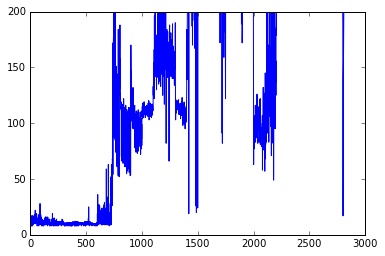

In [7]:
#plotting
from pylab import plot
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'valid')
rm=movingaverage(records, 100)
plt.plot(records)

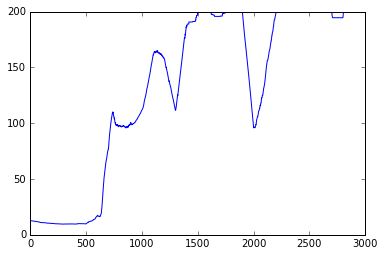

In [8]:
plt.plot(rm)

In [9]:
# DO NOT CHANGE CODE HERE
# after training, we will evaluate the performance of the agent
# on a target environment
eval_episodes = 100
record = []
env = gym.make('CartPole-v0')
eval_mode = True
for ite in range(eval_episodes):
    
    obs = env.reset()
    done = False
    rsum = 0
    
    while not done:
        if eval_mode:
            values = Qprincipal.compute_Qvalues(np.expand_dims(obs,0))
            action = np.argmax(values.flatten())
        else:
            raise NotImplementedError

        newobs, r, done, _ = env.step(action)
        rsum += r
        obs = newobs
    
    record.append(rsum)

print("eval performance of DQN agent: {}".format(np.mean(record)))

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
eval performance of DQN agent: 200.0


Submit this notebook using the following link https://www.instabase.com/apps/file-submission/cmd/submit/0b2b3203-887e-46fd-81b0-c1736e1670d1